In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import warnings
print("Setup Complete")

Setup Complete


### Read the kaggle datasets as dataframes and find out relevant information for modeling

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [3]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
# Target column "Transported" is missing in test data set
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [5]:
# unique id so the column can be dropped before modeling
len(train_data["PassengerId"].unique())

8693

In [6]:
# looks balanced so the column can be dropped before modeling 
len(train_data["Name"].unique())

8474

In [7]:
# looks balanced so the column can be dropped before modeling
len(train_data["Cabin"].unique())

6561

In [8]:
# see https://www.kaggle.com/code/vaasubisht/eda-statisticaltests-gradient-boosting-shap
# most of the columns have missing values but with low percentage compared to the amount of training data
missing_values = train_data.isna().sum().div(train_data.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing_values.columns  = ['% missing_values']
missing_values

,% missing_values
CryoSleep,2.496261
ShoppingMall,2.392730
VIP,2.335212
HomePlanet,2.312205
Name,2.300702
Cabin,2.289198
VRDeck,2.162660
FoodCourt,2.105142
Spa,2.105142
Destination,2.093639


### Visualize the unprepared training data

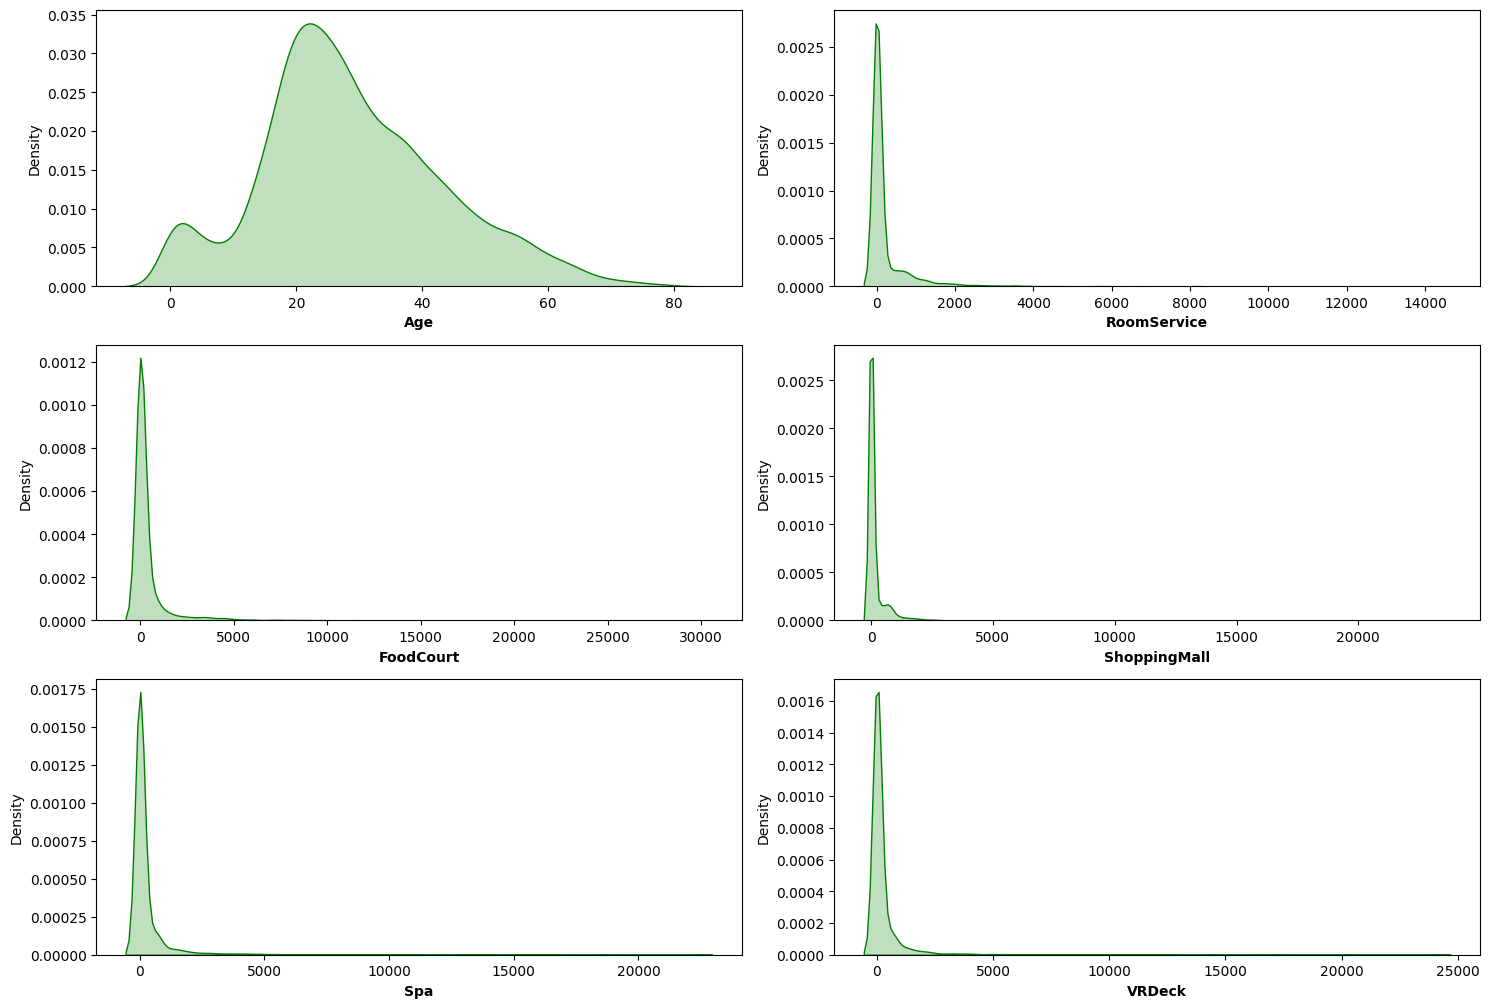

In [9]:
# see https://www.kaggle.com/code/vaasubisht/eda-statisticaltests-gradient-boosting-shap
num_columns = list(train_data[train_data.columns].select_dtypes(include=['float64']).columns)
cat_columns = list(train_data[train_data.columns].select_dtypes(include=['object']).columns)

# kernel density estimate subplots show that most of the numerical columns have inbalanced training data
warnings.filterwarnings("ignore")
plt.figure(figsize=(15, 100))
for i, col in enumerate(num_columns):
    plt.subplot(30, 2, i+1)
    sns.kdeplot(train_data[col], color='green', shade=True)
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

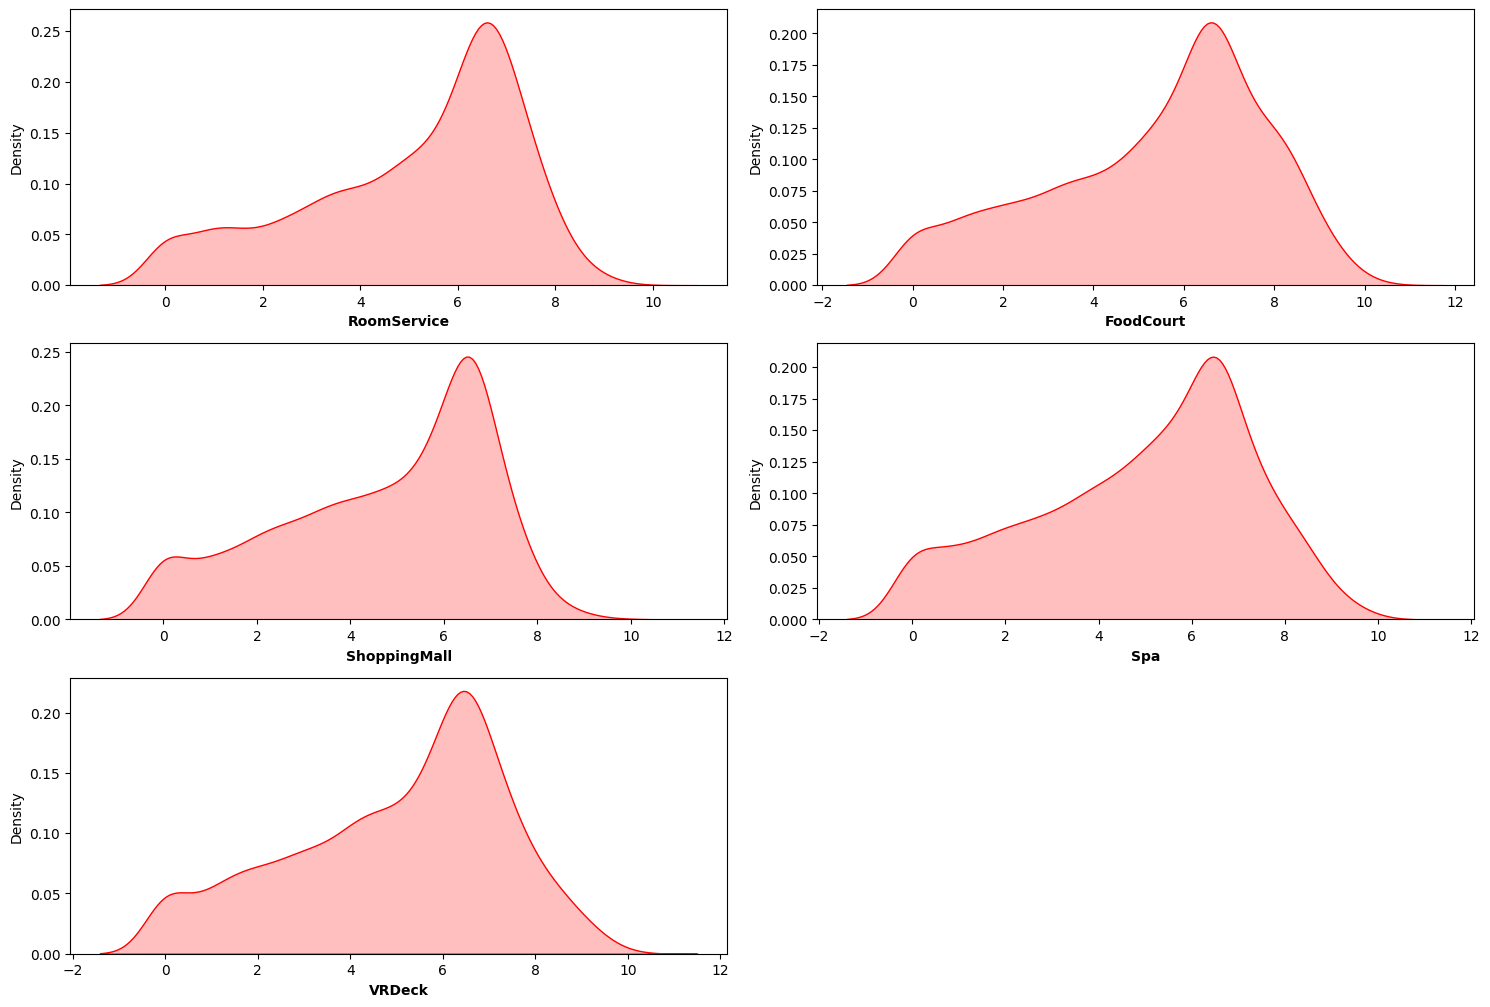

In [10]:
# see https://www.kaggle.com/code/vaasubisht/eda-statisticaltests-gradient-boosting-shap
inbalanced_columns = [col for col in num_columns if(train_data[col].skew()>1)]

# Possible solution could be to prepare the inbalanced columns with log transformation 
plt.figure(figsize=(15, 100))
for i, col in enumerate(inbalanced_columns):
    plt.subplot(30, 2, i+1)
    sns.kdeplot(np.log(train_data[col]),color='red',shade=True)
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

### Set the target column as index and visualize the training data

In [11]:
transported_index = train_data[train_data["Transported"]].set_index("Transported")
not_transported_index = train_data[train_data["Transported"] == False].set_index("Transported")

In [23]:
def plot_hist_subplots(col, title, bins="auto", discrete=None):
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,6))
    fig.suptitle(title)
    axes[0].set_title('Transported to new dimension')
    sns.histplot(data=transported_index[col], ax=axes[0], bins=bins, discrete=discrete)
    axes[1].set_title('Not transported to new dimension')
    sns.histplot(data=not_transported_index[col], ax=axes[1], bins=bins, discrete=discrete)

def plot_count_subplots(col, title):
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,6))
    fig.suptitle(title)
    axes[0].set_title('Transported to new dimension')
    sns.countplot(data=transported_index[col], ax=axes[0])
    axes[1].set_title('Not transported to new dimension')
    sns.countplot(data=not_transported_index[col], ax=axes[1])

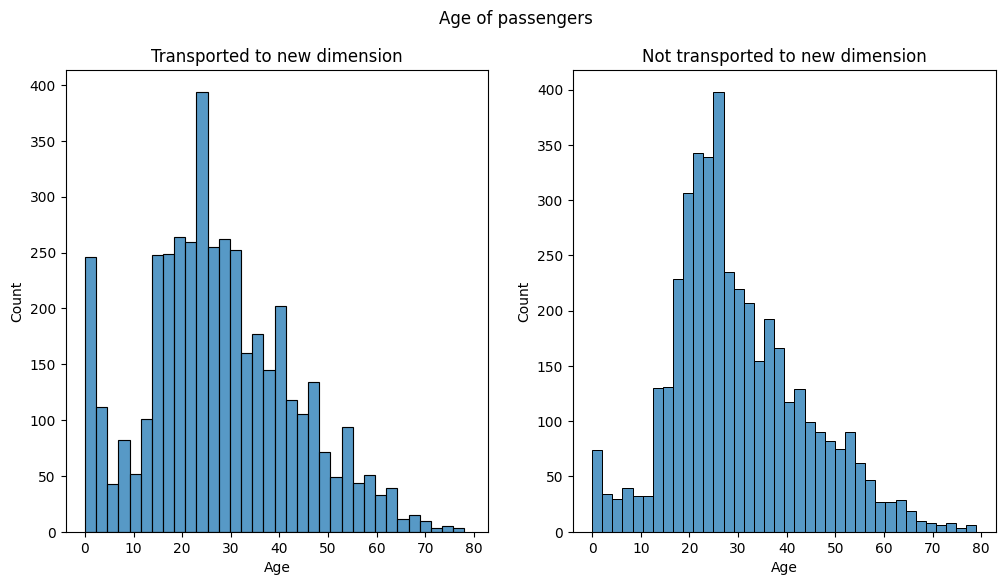

In [13]:
# distribution looks different, age seems to be relevant
plot_hist_subplots(col="Age", title="Age of passengers")

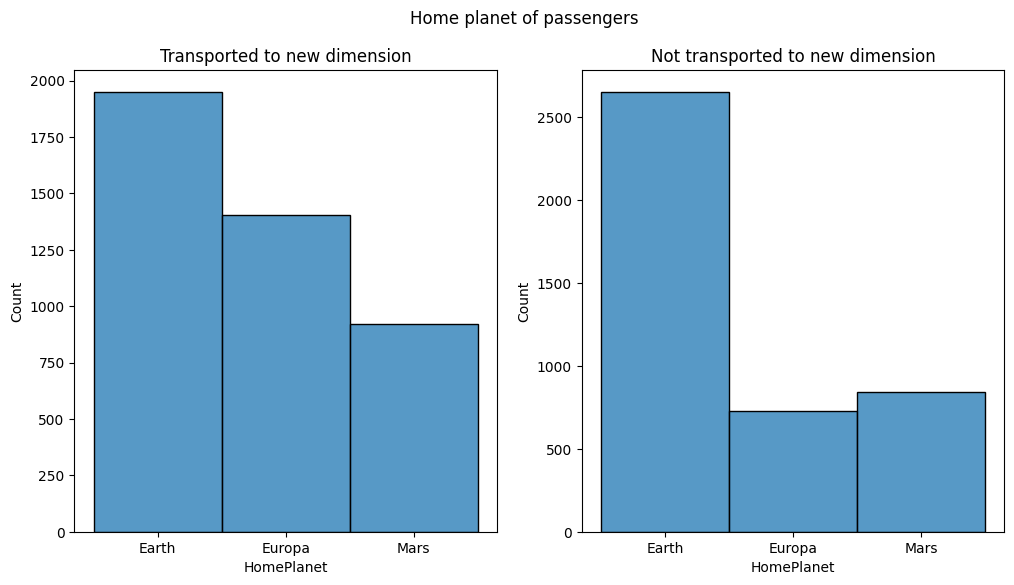

In [14]:
# distribution looks different, home planet seems to be relevant
plot_hist_subplots(col="HomePlanet", title="Home planet of passengers")

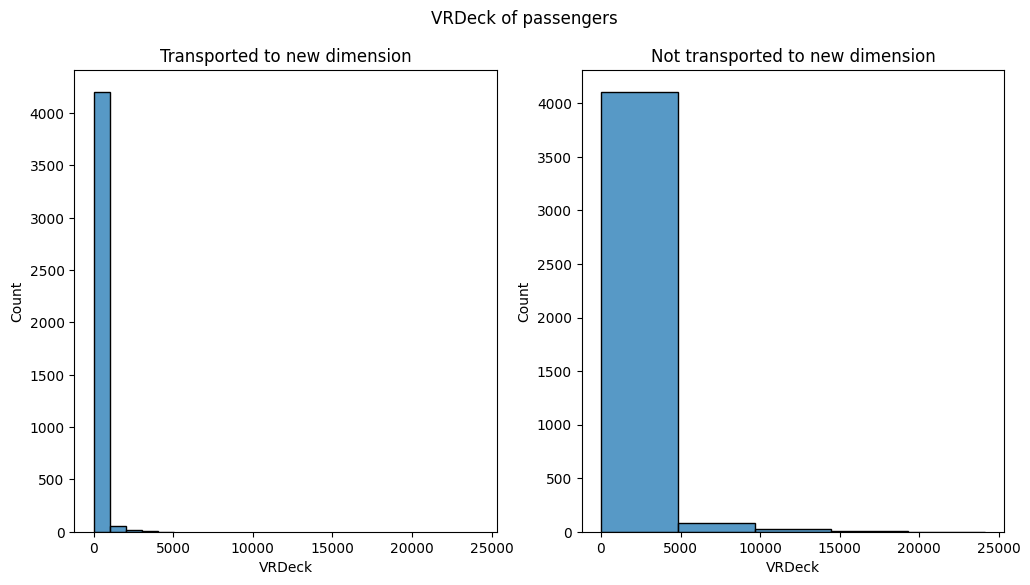

In [15]:
# VR deck looks similair, higher variance on the right
plot_hist_subplots(col="VRDeck", title="VRDeck of passengers", bins=5)

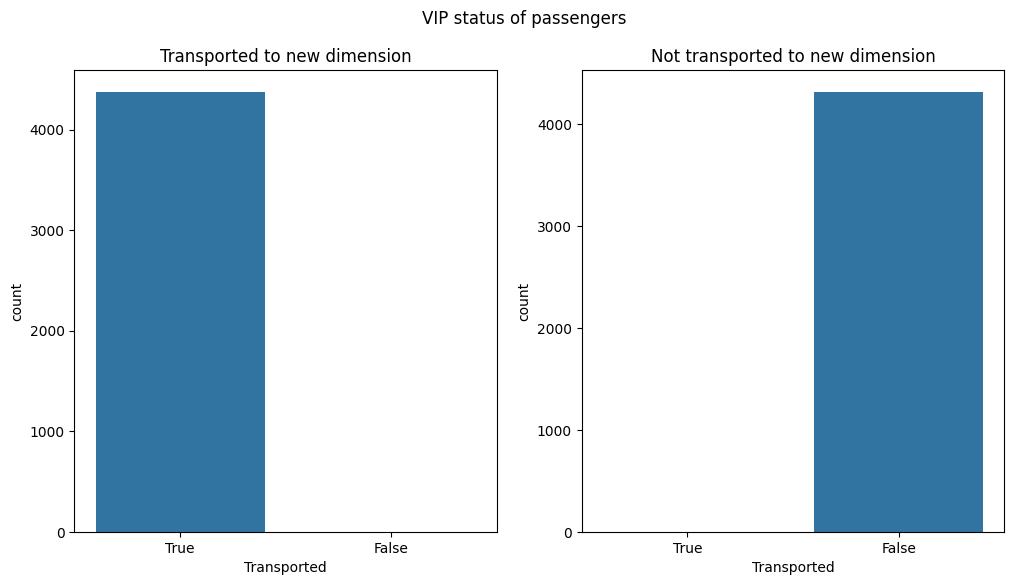

In [24]:
# VIP seems to have no effect
plot_count_subplots(col="VIP", title="VIP status of passengers")

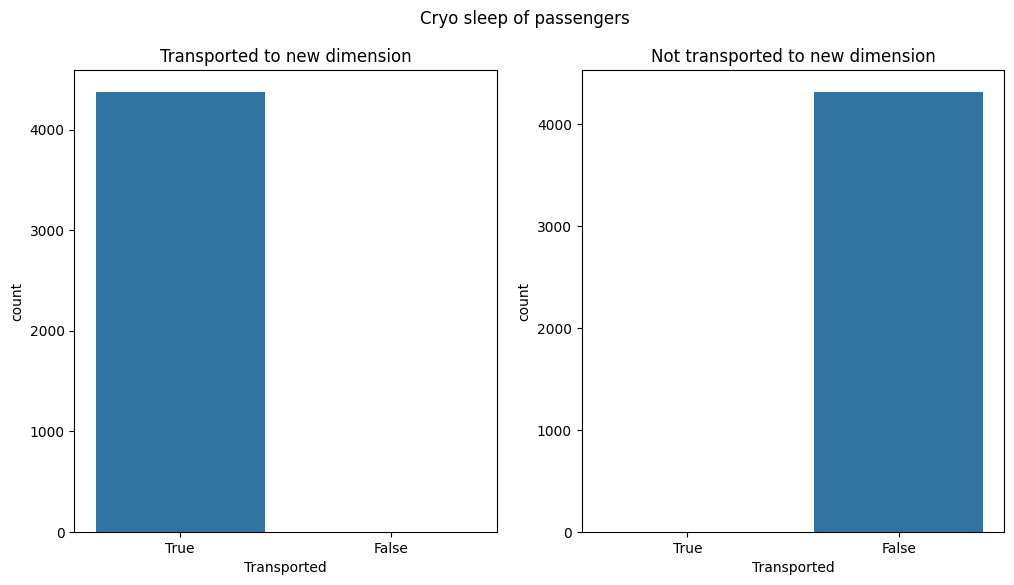

In [17]:
# distribution looks different, cryo sleep seems to be relevant
plot_count_subplots(col="CryoSleep", title="Cryo sleep of passengers")

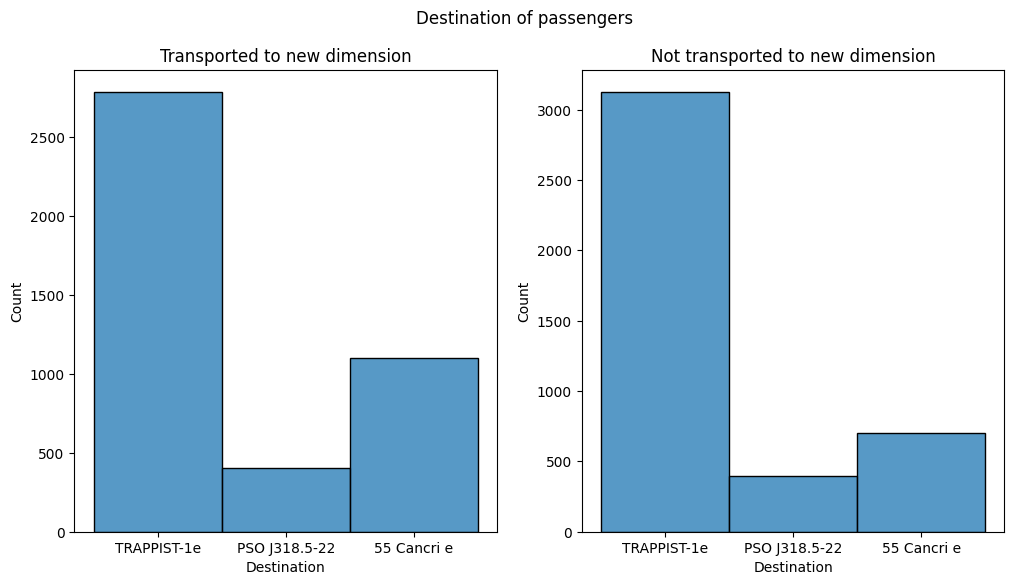

In [18]:
# VR deck looks similair, probably a small effect
plot_hist_subplots(col="Destination", title="Destination of passengers")

### Further analysis of target column differences with relationship (x, y) plots

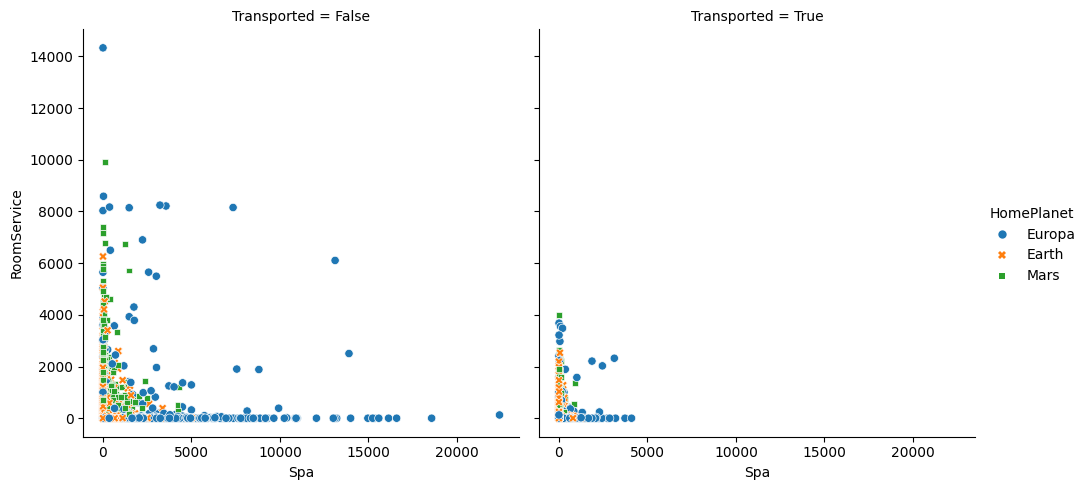

In [19]:
sns.relplot(data=train_data, x="Spa", y="RoomService", col="Transported", hue="HomePlanet", style="HomePlanet")

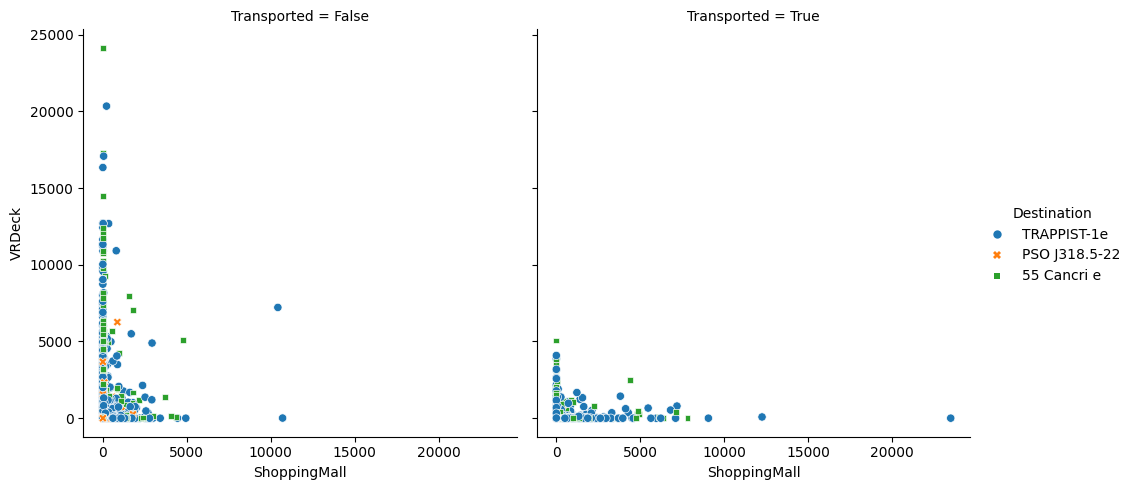

In [20]:
sns.relplot(data=train_data, x="ShoppingMall", y="VRDeck", col="Transported", hue="Destination", style="Destination")

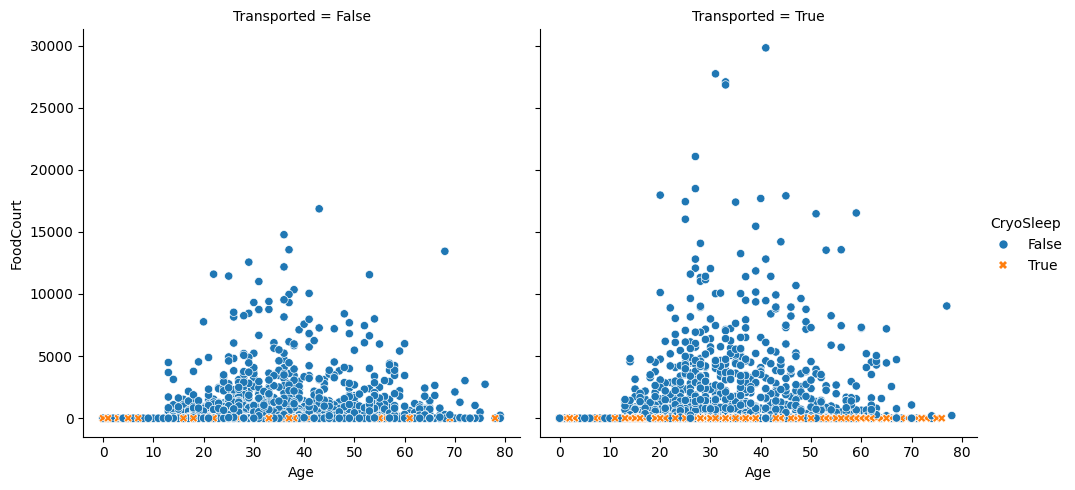

In [21]:
sns.relplot(data=train_data, x="Age", y="FoodCourt", col="Transported", hue="CryoSleep", style="CryoSleep")